In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample

In [2]:
df = pd.read_csv(
    '/Users/uditrawat/Desktop/CardioX/artifacts/data_ingestion/heart_2020_cleaned.csv')

df.drop(['AgeCategory', 'Race', 'GenHealth'], inplace=True, axis=1)



In [3]:

X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

le = LabelEncoder()

for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

In [5]:
chi_selector = SelectKBest(chi2, k=5)
X_train_top5 = chi_selector.fit_transform(X_train, y_train)

top5_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top5_features)}")

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [6]:
X_test_top5 = chi_selector.transform(X_test)

train_data = pd.concat([pd.DataFrame(
    X_train_top5, columns=top5_features), y_train.reset_index(drop=True)], axis=1)


majority = train_data[train_data['HeartDisease'] == 0]
minority = train_data[train_data['HeartDisease'] == 1]


majority_downsampled = resample(majority,
                                replace=False,            # Sample without replacement
                                # Match minority class sample size
                                n_samples=len(minority),
                                random_state=42)          # Random seed for reproducibility

# Combine minority class with downsampled majority class
train_data_balanced = pd.concat([majority_downsampled, minority])

# Shuffle the balanced data
train_data_balanced = train_data_balanced.sample(
    frac=1, random_state=42).reset_index(drop=True)

# Step 5: Prepare train and test sets with selected features
X_train_final = train_data_balanced.drop(columns=['HeartDisease'])
y_train_final = train_data_balanced['HeartDisease']

# X_test_top5 is already created earlier
print("Train and test data preparation complete.")

Train and test data preparation complete.


In [7]:
from sklearn.metrics import classification_report

In [16]:
# Step 3: Use Chi-Square with SelectKBest to select top 5 features on training data
chi_selector = SelectKBest(chi2, k=5)

# Fit on the training data and transform it
X_train_top5 = chi_selector.fit_transform(X_train, y_train)

# Get the names of the selected features
top5_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top5_features)}")

# Now, apply the same transformation to the test data
X_test = chi_selector.transform(X_test)

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [18]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_final,y_train_final)
pred = dt.predict(X_test)

/Users/uditrawat/Desktop/CardioX/cardiox-env/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [20]:
print("classification report", '\n', classification_report(y_test, pred))

classification report 
               precision    recall  f1-score   support

           0       0.96      0.75      0.84     58484
           1       0.19      0.63      0.29      5475

    accuracy                           0.74     63959
   macro avg       0.57      0.69      0.57     63959
weighted avg       0.89      0.74      0.79     63959



In [9]:
X_train_final

,Stroke,PhysicalHealth,DiffWalking,Diabetic,KidneyDisease
0,1.0,0.0,0.0,2.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,2.0,0.0
3,1.0,7.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
43791,0.0,0.0,0.0,0.0,0.0
43792,0.0,0.0,0.0,0.0,0.0
43793,0.0,3.0,0.0,0.0,0.0
43794,0.0,0.0,0.0,0.0,0.0


In [17]:
X_test

array([[ 0., 30.,  0.,  2.,  0.],
       [ 0., 25.,  1.,  0.,  0.],
       [ 0.,  3.,  0.,  0.,  0.],
       ...,
       [ 0.,  2.,  0.,  0.,  1.],
       [ 0.,  2.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.]])

In [22]:
df.head(1)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.6,Yes,No,No,3.0,30.0,No,Female,Yes,Yes,5.0,Yes,No,Yes


In [28]:
df['HeartDisease'].value_counts()

HeartDisease
No     292422
Yes     27373
Name: count, dtype: int64

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv(
    '/Users/uditrawat/Desktop/CardioX/artifacts/data_ingestion/heart_2020_cleaned.csv')

df.drop(['AgeCategory', 'Race', 'GenHealth'], inplace=True, axis=1)

In [4]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Convert target to binary labels
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


chi_selector = SelectKBest(chi2, k=5)
X_train_top5 = chi_selector.fit_transform(X_train, y_train)
X_test_top5 = chi_selector.transform(X_test)

top5_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top5_features)}")

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [6]:
smote = SMOTE(random_state=42)
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(
    X_train_top5, y_train)

In [7]:
# Step 4: Train an XGBoost model with class weights
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) /
                          len(y_train_resampled[y_train_resampled == 1]), random_state=42)

In [8]:


xgb_model.fit(X_train_resampled, y_train_resampled)

# Step 5: Make predictions
y_pred = xgb_model.predict(X_test_top5)
y_pred_proba = xgb_model.predict_proba(X_test_top5)[:, 1]

In [9]:


# Step 6: Evaluate the model (Classification report and AUC-ROC)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     58484
           1       0.19      0.63      0.30      5475

    accuracy                           0.74     63959
   macro avg       0.57      0.69      0.57     63959
weighted avg       0.89      0.74      0.80     63959



In [10]:

# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc}")

AUC-ROC Score: 0.7274668496148813


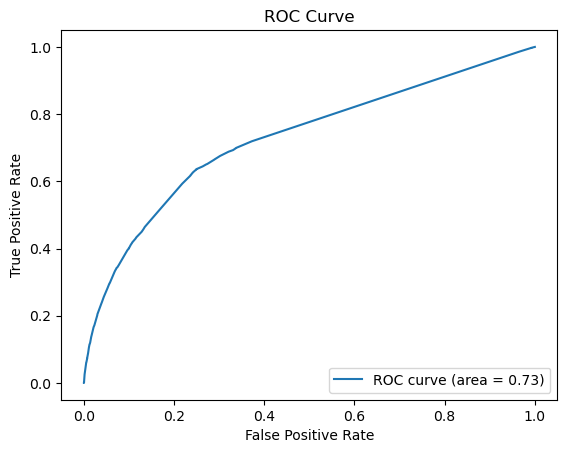

In [11]:
# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

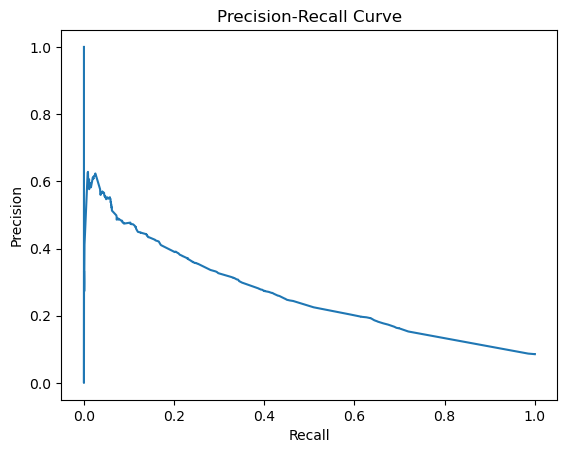

In [12]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [ ]:




# Step 7: Tuning the threshold (optional)
optimal_threshold = 0.5  # Start with the default 0.5
y_pred_threshold = (y_pred_proba >= optimal_threshold).astype(int)

# Adjust the threshold to optimize precision/recall balance

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv(
    '/Users/uditrawat/Desktop/CardioX/artifacts/data_ingestion/heart_2020_cleaned.csv')

df.drop(['AgeCategory', 'Race', 'GenHealth'], inplace=True, axis=1)

In [3]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']


y = y.apply(lambda x: 1 if x == 'Yes' else 0)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])


chi_selector = SelectKBest(chi2, k=5)
X_train_top5 = chi_selector.fit_transform(X_train, y_train)
X_test_top5 = chi_selector.transform(X_test)

top5_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top5_features)}")

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [4]:
# Step 3: Balance the data using SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(
    X_train_top5, y_train)

In [5]:
# Define parameter grids for XGBoost and LightGBM
xgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])]
}

lgbm_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [1, len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])]
}

# Choose XGBoost or LightGBM for tuning
xgb_model = XGBClassifier(random_state=42)
lgbm_model = LGBMClassifier(random_state=42)

In [6]:
# RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_grid,
                                n_iter=10, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
xgb_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'scale_pos_weight': [1,
                                                             24.17776950750527],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='roc_auc')

In [7]:
best_model = xgb_search.best_estimator_
# best_model = lgbm_search.best_estimator_  # Use this line for LightGBM

In [8]:
# Step 5: Make predictions
y_pred = best_model.predict(X_test_top5)
y_pred_proba = best_model.predict_proba(X_test_top5)[:, 1]

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     58484
           1       0.23      0.26      0.24      5475

    accuracy                           0.86     63959
   macro avg       0.58      0.59      0.58     63959
weighted avg       0.87      0.86      0.87     63959



In [10]:
# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc}")

AUC-ROC Score: 0.6991099138381992


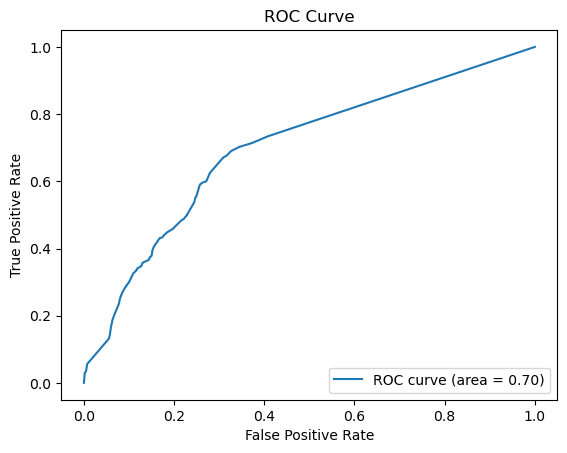

In [11]:
# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

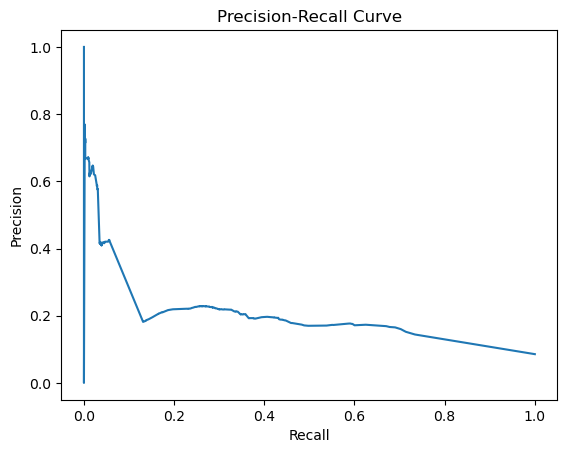

In [12]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [13]:
# RandomizedSearchCV for LightGBM (if you prefer this instead)
lgbm_search = RandomizedSearchCV(lgbm_model, param_distributions=lgbm_param_grid, n_iter=10, cv=3, random_state=42, scoring='roc_auc', n_jobs=-1)
lgbm_search.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Number of positive: 5374, number of negative: 129932
[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Number of positive: 5374, number of negative: 129931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 834
[LightGBM] [Info] Number of data points in the train set: 135305, number of used features: 5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_w

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 500],
                                        'num_leaves': [20, 31, 40],
                                        'scale_pos_weight': [1,
                                                             24.17776950750527],
                                        'subsample': [0.5, 0.7, 1.0]},
                   random_state=42, scoring='roc_auc')

In [14]:
best_model = lgbm_search.best_estimator_  # Use this line for LightGBM

In [15]:
# Step 5: Make predictions
y_pred = best_model.predict(X_test_top5)
y_pred_proba = best_model.predict_proba(X_test_top5)[:, 1]

In [16]:
# Step 6: Evaluate the model (Classification report and AUC-ROC)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     58484
           1       0.39      0.10      0.16      5475

    accuracy                           0.91     63959
   macro avg       0.65      0.54      0.56     63959
weighted avg       0.88      0.91      0.88     63959



In [17]:
# AUC-ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC Score: {roc_auc}")

AUC-ROC Score: 0.6989160802361276


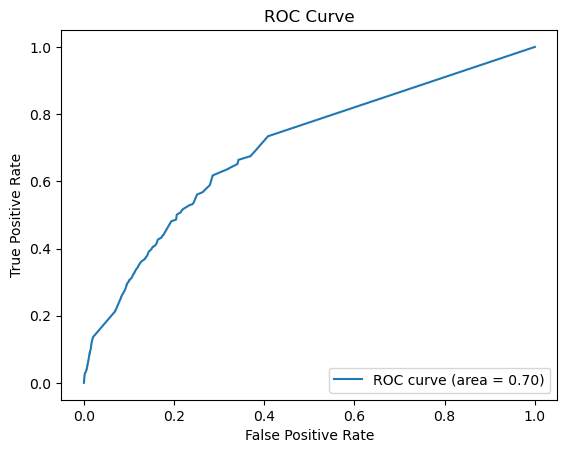

In [18]:
# Plotting ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

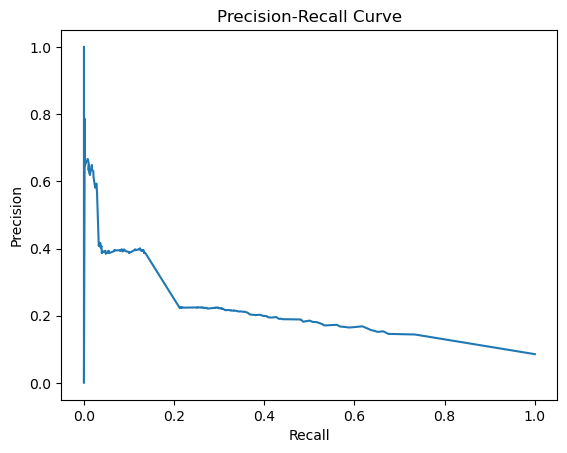

In [19]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()



In [20]:
from imblearn.under_sampling import TomekLinks

In [21]:
df = pd.read_csv(
    '/Users/uditrawat/Desktop/CardioX/artifacts/data_ingestion/heart_2020_cleaned.csv')

df.drop(['AgeCategory', 'Race', 'GenHealth'], inplace=True, axis=1)

In [22]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

# Convert target to binary labels
y = y.apply(lambda x: 1 if x == 'Yes' else 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Apply Label Encoding (if needed)
le = LabelEncoder()
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = le.fit_transform(X_train[col])
        X_test[col] = le.transform(X_test[col])

# Step 2: Feature Selection using Chi-Square
chi_selector = SelectKBest(chi2, k=5)
X_train_top5 = chi_selector.fit_transform(X_train, y_train)
X_test_top5 = chi_selector.transform(X_test)

top5_features = X_train.columns[chi_selector.get_support()]
print(f"Top 5 selected features: {list(top5_features)}")

Top 5 selected features: ['Stroke', 'PhysicalHealth', 'DiffWalking', 'Diabetic', 'KidneyDisease']


In [23]:
# Step 3: Balance the data using Tomek Links to clean up the majority class
tomek = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek.fit_resample(
    X_train_top5, y_train)

In [24]:
# Step 4: Train an XGBoost model with adjusted class weights
xgb_model = XGBClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) /
                          len(y_train_resampled[y_train_resampled == 1]),
                          random_state=42, use_label_encoder=False, eval_metric='logloss')

xgb_model.fit(X_train_resampled, y_train_resampled)

/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [22:37:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [25]:

# Step 5: Train a LightGBM model with adjusted class weights
lgbm_model = LGBMClassifier(scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) /
                            len(y_train_resampled[y_train_resampled == 1]),
                            random_state=42)

lgbm_model.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Number of positive: 21898, number of negative: 233938
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41
[LightGBM] [Info] Number of data points in the train set: 255836, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085594 -> initscore=-2.368661
[LightGBM] [Info] Start training from score -2.368661


LGBMClassifier(random_state=42, scale_pos_weight=10.683076080007307)

In [26]:
# Step 6: Make predictions and evaluate XGBoost model
y_pred_xgb = xgb_model.predict(X_test_top5)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_top5)[:, 1]

In [27]:
# Step 7: Make predictions and evaluate LightGBM model
y_pred_lgbm = lgbm_model.predict(X_test_top5)
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test_top5)[:, 1]

In [28]:
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("LightGBM Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     58484
           1       0.19      0.64      0.30      5475

    accuracy                           0.74     63959
   macro avg       0.57      0.69      0.57     63959
weighted avg       0.89      0.74      0.79     63959

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     58484
           1       0.19      0.64      0.30      5475

    accuracy                           0.74     63959
   macro avg       0.57      0.69      0.57     63959
weighted avg       0.89      0.74      0.79     63959



In [29]:
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"XGBoost AUC-ROC Score: {roc_auc_xgb}")


roc_auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"LightGBM AUC-ROC Score: {roc_auc_lgbm}")

XGBoost AUC-ROC Score: 0.7284498090099341
LightGBM AUC-ROC Score: 0.7289057445052293


In [30]:
# Plot ROC Curve for both models
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_proba_lgbm)

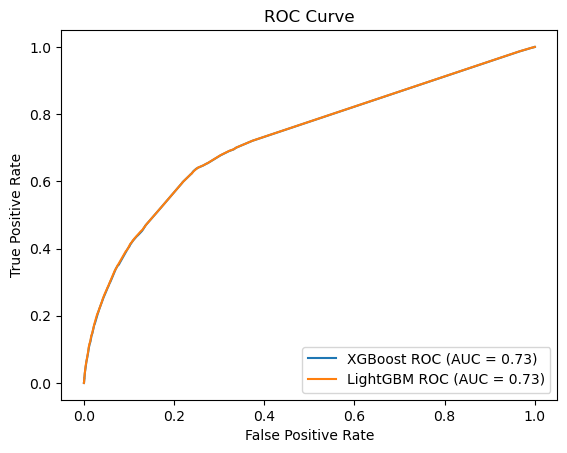

In [31]:
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost ROC (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM ROC (AUC = {roc_auc_lgbm:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:

# Precision-Recall Curve
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
precision_lgbm, recall_lgbm, _ = precision_recall_curve(
    y_test, y_pred_proba_lgbm)

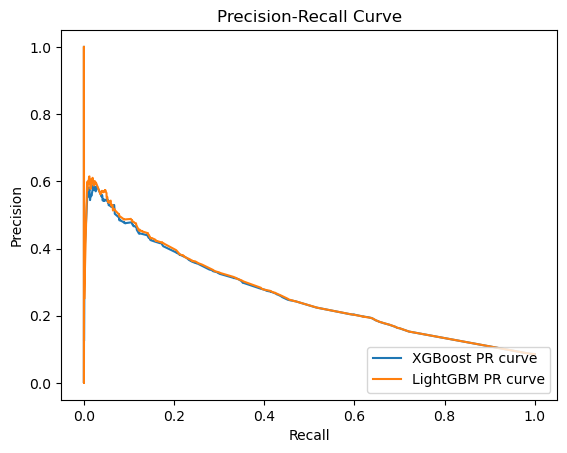

In [33]:





plt.plot(recall_xgb, precision_xgb, label='XGBoost PR curve')
plt.plot(recall_lgbm, precision_lgbm, label='LightGBM PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [35]:
df.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'Diabetic',
       'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease',
       'SkinCancer'],
      dtype='object')

In [36]:
import seaborn as sns

In [37]:
# Convert HeartDisease to binary
df['HeartDisease'] = df['HeartDisease'].apply(lambda x: 1 if x == 'Yes' else 0)

In [44]:
le = LabelEncoder()
for col in X_train.columns:
    if df[col].dtype == 'object':
        df[col] = le.fit_transform(df[col])


In [42]:
df.dtypes

HeartDisease          int64
BMI                 float64
Smoking              object
AlcoholDrinking      object
Stroke               object
PhysicalHealth      float64
MentalHealth        float64
DiffWalking          object
Sex                  object
Diabetic             object
PhysicalActivity     object
SleepTime           float64
Asthma               object
KidneyDisease        object
SkinCancer           object
dtype: object

In [45]:
df

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,Diabetic,PhysicalActivity,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,2,1,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,0,1,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,2,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,0,0,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,0,1,8.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319790,1,27.41,1,0,0,7.0,0.0,1,1,2,0,6.0,1,0,0
319791,0,29.84,1,0,0,0.0,0.0,0,1,0,1,5.0,1,0,0
319792,0,24.24,0,0,0,0.0,0.0,0,0,0,1,6.0,0,0,0
319793,0,32.81,0,0,0,0.0,0.0,0,0,0,0,12.0,0,0,0


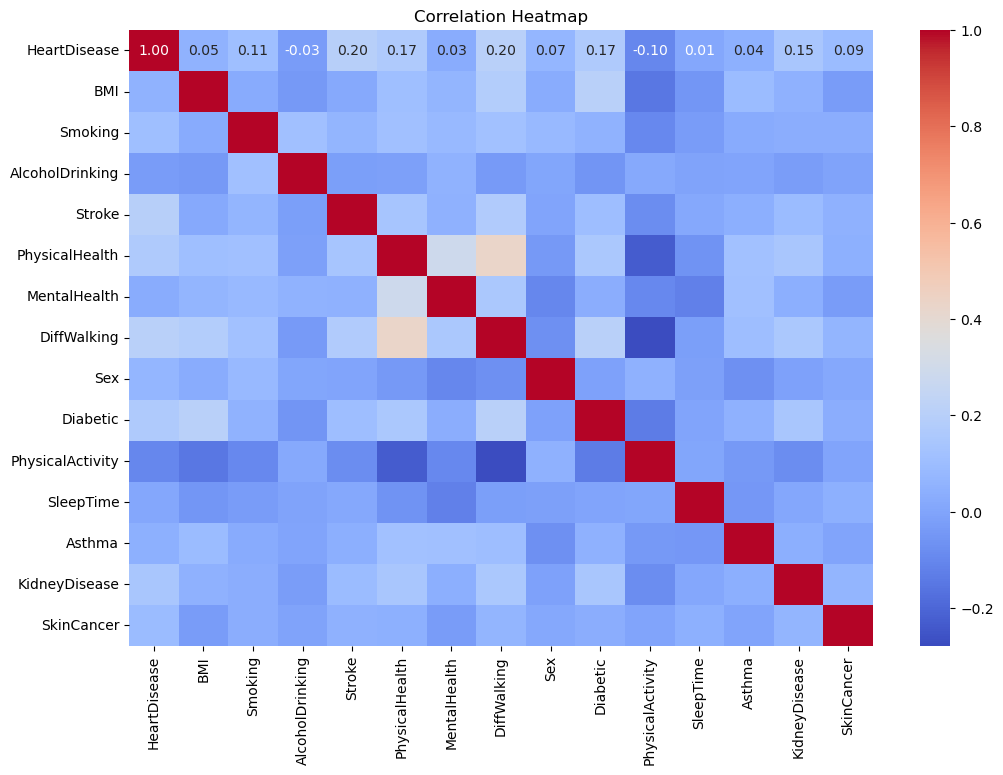

In [46]:
# Step 1: Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

AttributeError: 'numpy.int64' object has no attribute 'startswith'

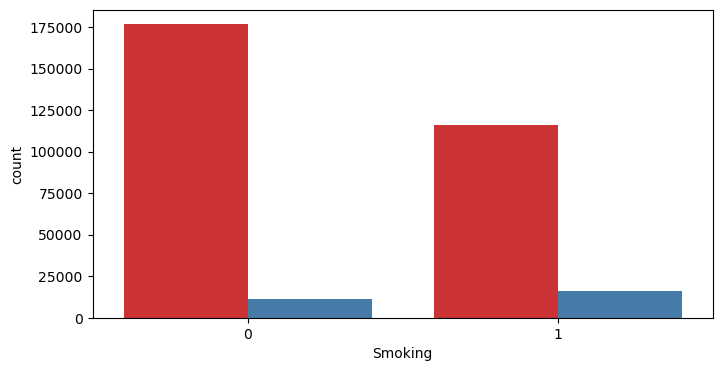

In [47]:
# Step 2: Value Counts for categorical variables and HeartDisease class separation
categorical_columns = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
                       'Diabetic', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='HeartDisease', data=df, palette='Set1')
    plt.title(f'Count of HeartDisease by {col}')
    plt.show()

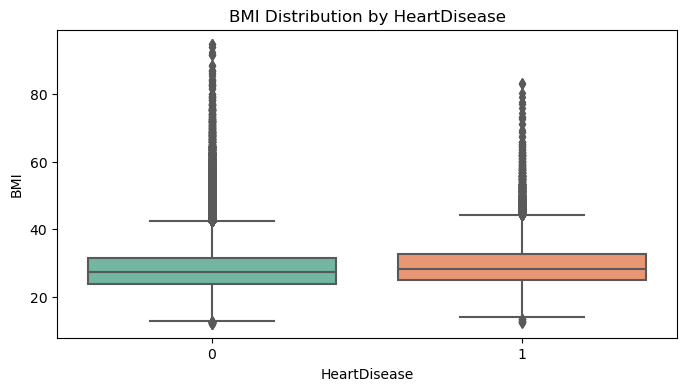

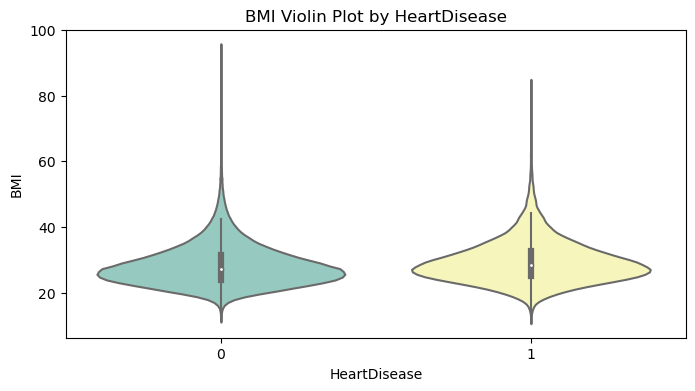

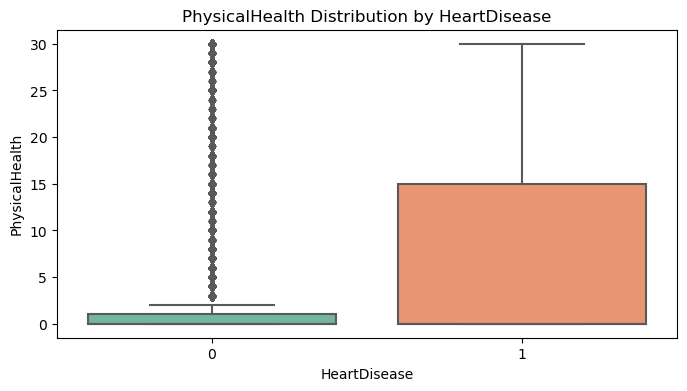

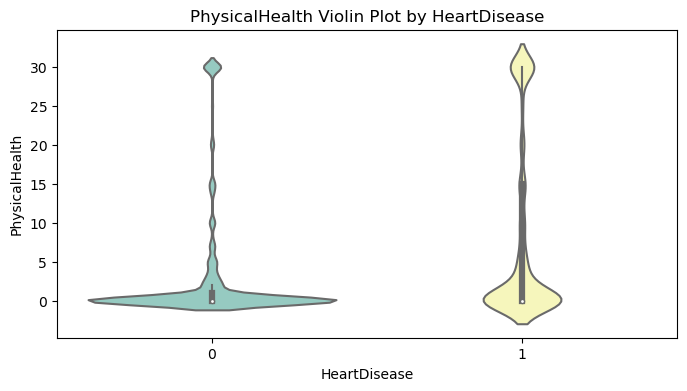

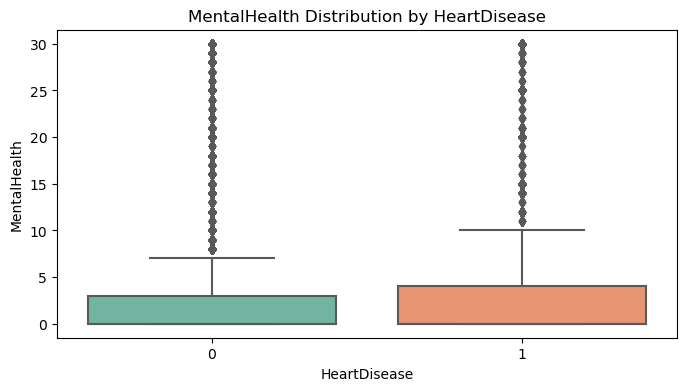

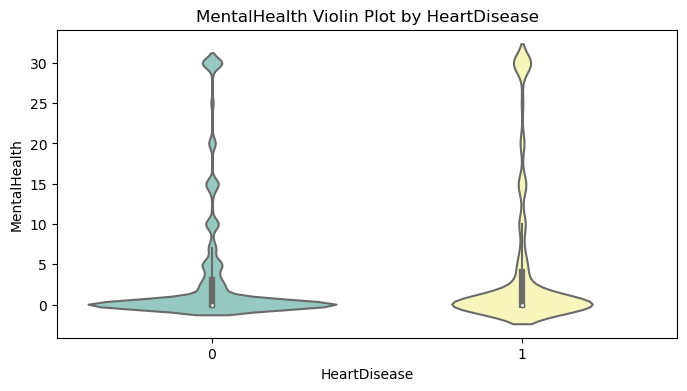

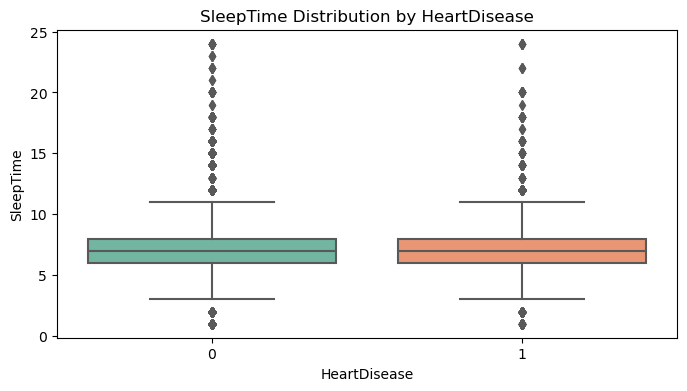

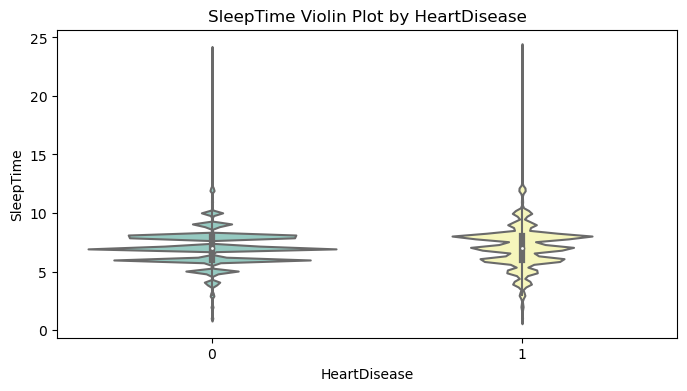

In [48]:
# Step 3: Boxplot/Violinplot for continuous variables
continuous_columns = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

for col in continuous_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='HeartDisease', y=col, data=df, palette='Set2')
    plt.title(f'{col} Distribution by HeartDisease')
    plt.show()

    # Optionally, violin plot to show distribution more clearly
    plt.figure(figsize=(8, 4))
    sns.violinplot(x='HeartDisease', y=col, data=df, palette='Set3')
    plt.title(f'{col} Violin Plot by HeartDisease')
    plt.show()

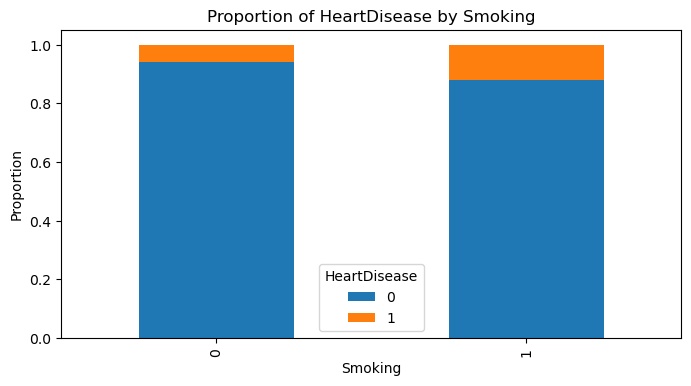

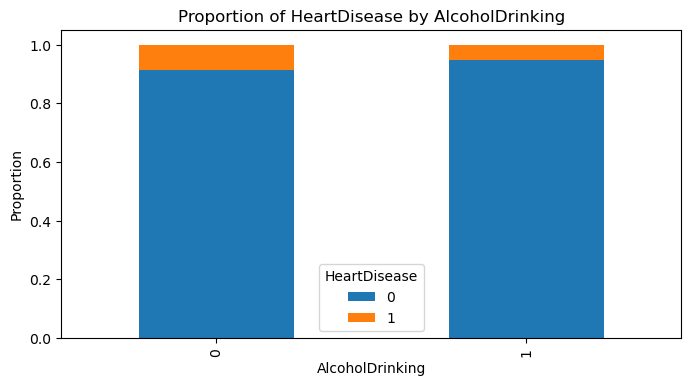

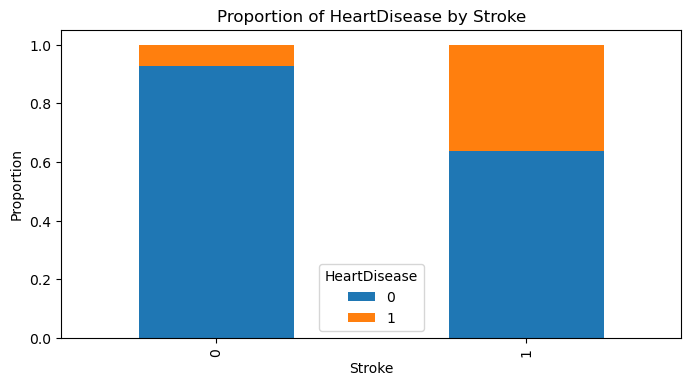

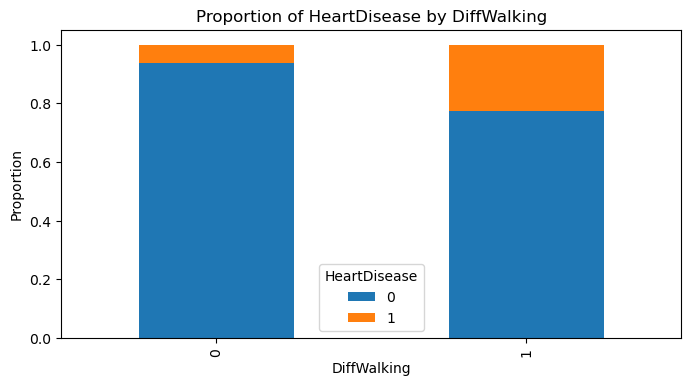

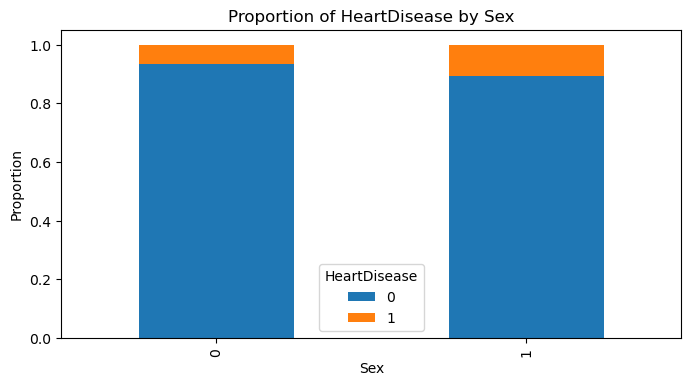

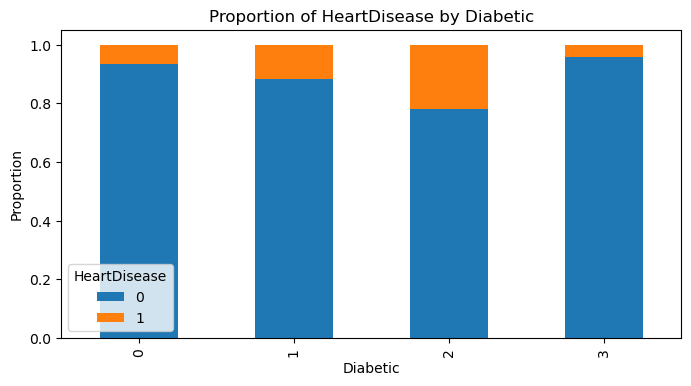

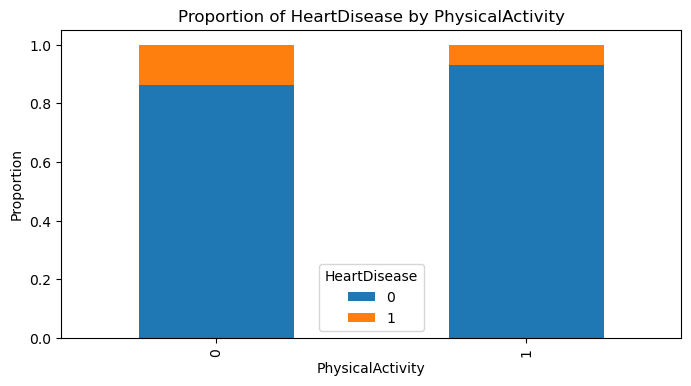

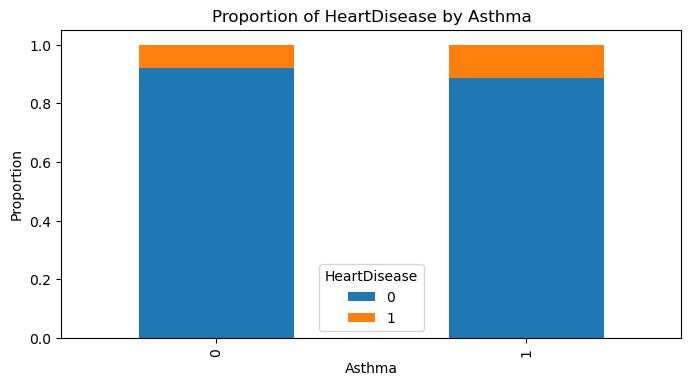

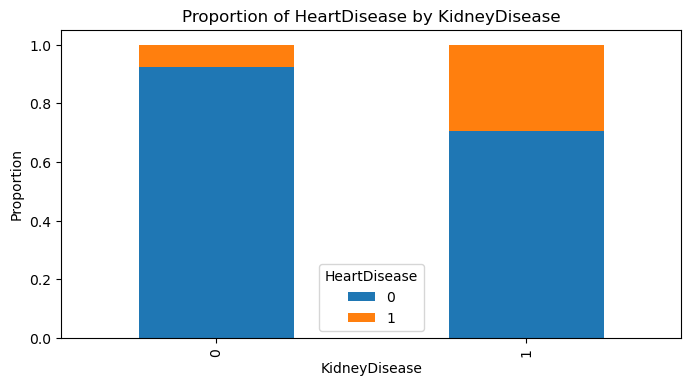

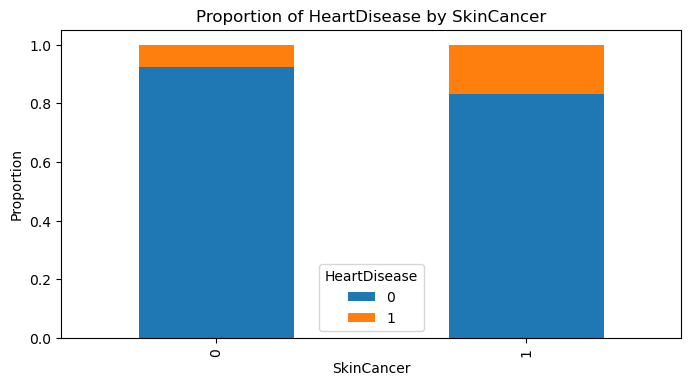

In [49]:








# Step 4: Barplot for categorical proportions
for col in categorical_columns:
    heartdisease_proportion = pd.crosstab(
        df[col], df['HeartDisease'], normalize='index')
    heartdisease_proportion.plot(kind='bar', stacked=True, figsize=(
        8, 4), color=['#1f77b4', '#ff7f0e'])
    plt.title(f'Proportion of HeartDisease by {col}')
    plt.ylabel('Proportion')
    plt.show()

